Reproducing image generation 

In [ ]:
import os
os.environ["MKL_NUM_THREADS"]="16" 
os.environ["NUMEXPR_NUM_THREADS"]='16'
os.environ["OMP_NUM_THREADS"]='16'
import matplotlib.pyplot as plt
import types
import numpy as np
from tqdm import notebook
from mmd import MMD_3_Sample_Test
import torch
from torch import optim

%matplotlib inline

from importlib import reload
import torchvision

import Generators, Features, Data, Likelihoods

import KernelWakeSleep as kws

device = torch.device("cuda:0")
reload(Data);

In [ ]:
batch_size = 100

dname = "mnist"
binary= True and dname == "mnist"
nc = 3 if dname in ["cifar", "celeb"] else 1


nsleep = 2000
nepoch = 20
nvalid = 200

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

train_loader, test_images = Data.load_data(dname, binary=binary, ntrain=10**5, ntest=10**4, image_size=32, batch_size=batch_size)
Dx = test_images.shape[-1]
image_size = int(np.sqrt(Dx//nc))

In [ ]:
reload(Generators)
reload(Features)
reload(Likelihoods)

In [4]:
D0 = 16
log_noise = torch.zeros((), requires_grad=True, device=device)

if dname == "van":
    tanh = sigmoid = False
else:
    tanh = not binary
    sigmoid = binary
    
ngf = 64
# generative model
prior = torch.distributions.Normal(torch.zeros(D0, device=device), torch.ones(D0,device=device))


# fully connected generator
# gen_network = Generators.fc_gen(D0,512,512,image_size**2*nc,tanh=tanh, sigmoid=False).to(device)

# convolutional generator
gen_network = Generators.dc_gen(D0,ngf, tanh=tanh, sigmoid=sigmoid, nc=nc).to(device)

if not binary:
    obs   = Likelihoods.GaussianObservation(gen_network, log_noise)
else:
    obs   = Likelihoods.BernoulliObservation(gen_network)

In [8]:
# separate kernel networks into multiple ones with narrow output width 
# so that inner product in the kernel is cheaper
nnet = 1
block_size= 100

reload(kws)

data = kws.draw_sample(prior, obs, nsleep)

# compose network for the kernel
kernel_networks = []

# gather features for median computation
Fdata = []
for i in range(nnet):
    
    # no network
    # k = torch.nn.Identity()
    
    # linear network followed by batch norm (in the papaer)
    k = Features.lin_feat(Dx, block_size, bn=True).to(device)

    # convolutional network followed by batch norm
    # k = Features.dc_feat(image_size,ngf, nfinal=100, bn=False, nl=True, nc=nc).to(device)
    k.apply(kws.weights_init)
    
    Fdata += k(data),
    kernel_networks += k,
    
Fdata   = torch.cat(Fdata, -1) 
Fmedian =  kws.estimate_median_distance(Fdata)


# kernel_networks = [torch.nn.BatchNorm1d(Dx).to(device)]
# kernel = kws.Kernel(kernel_networks, Fmedian, lam=1e-3, train_sigma=True, train_lam=True).to(device)
kernel = kws.RFKernel(100, kernel_networks, sigma=Fmedian, nfeat=2000, lam=1e-3, train_sigma=True, train_lam=True).to(device)

In [9]:
optimizer = optim.Adam(list(gen_network.parameters())+[log_noise], lr=0.001)
kernel_optimizer = optim.Adam(kernel.parameters(), lr=0.001)


Elogps = []
losses = []

log_lams = []
log_sigmas = []

network_norms = []
kernel_network_norms = []
kernel_network_feat_norms = []
noise_stds = []
network_grad_norms = []

feat_mmds = []
recons = []

In [ ]:
nsleep = 5000

gen_network.train()
kernel.train()

for ei in notebook.tqdm(range(50)):
    
    with notebook.tqdm(train_loader, leave=False) as t:
        for i, (X_tr,) in enumerate(t):
        
            X_tr = X_tr.float().to(device)

            
            if ei >= 0:
                

                data_0, data_1, norm, nat = kws.sleep(prior, obs, nsleep)
                data_0_val, data_1_val, norm_val, nat_val = kws.sleep(prior, obs, 200, detach=True)
                S_val = obs.suff(data_1_val)
                
                kernel_optimizer.zero_grad()


                # Elogp_val = KRR_old(obs.suff,deep_gaussian_gram, data_1_val, data_1, norm.detach(), nat.detach(), 
                #                 log_sigma, log_lam, noise = 0.0*binary)
                Elogp_val = kws.KRR_2(obs.suff, kernel, data_1_val, data_1, norm, nat)

                loss_val = torch.mean((Elogp_val + norm_val - (nat_val * S_val).sum(-1))**2)

#                 kernel_network_norm = sum([sum(
#                                             map(lambda x: (x**2).sum(), k.parameters())
#                                                 )
#                                            for k in kernel_networks])
#                 kernel_network_norms += kernel_network_norm.cpu().detach().numpy(),
                
                loss_val = loss_val

                loss_val.backward(retain_graph=False)
                
#                 for k in kernel.kernel_networks:
#                     k[1].weight.data /= k[1].weight.data.norm(2, dim=-1, keepdim=True)
#                     k[4].weight.data /= k[4].weight.data.norm(2, dim=-1, keepdim=True)
                
                kernel_optimizer.step()


                log_lams += kernel.log_lam.cpu().detach().numpy(),
                log_sigmas += kernel.log_sigma.cpu().detach().numpy(),
                losses += loss_val.detach().cpu().numpy(),
                    
            data_0, data_1, norm, nat = kws.sleep(prior, obs, nsleep)
            
            # Elogp = KRR_old(obs.suff,deep_gaussian_gram, X_tr, data_1, norm, nat, log_sigma, log_lam)
            Elogp  = kws.KRR_2(obs.suff, kernel, X_tr, data_1, norm, nat).mean() 
            
            gen_loss = -Elogp
            
            t.set_postfix(Elogp=Elogp.item())

            Elogps += Elogp.detach().cpu().numpy(),

            optimizer.zero_grad()
            gen_loss.backward(retain_graph=False)
                        
            network_norm = sum(map(lambda x: (x**2).sum(), gen_network.parameters()))
            network_norms += network_norm,
            network_grad_norm = sum(map(lambda x: (x.grad**2).sum(), gen_network.parameters()))
            network_grad_norms += network_grad_norm,

            optimizer.step()

            if not binary:
                noise_stds += obs.log_std.exp().detach().cpu().numpy(),

In [39]:
torch.cuda.empty_cache()

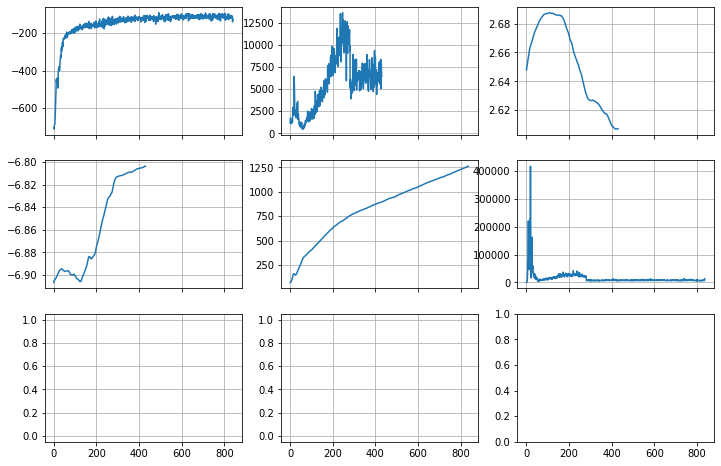

In [46]:
params = [Elogps,losses, log_sigmas, 
          log_lams, network_norms, network_grad_norms, 
          kernel_network_norms, noise_stds]


nplot = len(params)
fig, axes = plt.subplots(3,nplot//3+1, figsize=(12,8), sharex=True)
axes = np.ravel(axes)
for i in range(nplot):
    axes[i].plot(params[i])
    axes[i].grid(True)
# axes[0].set_xlim([20000,2000])

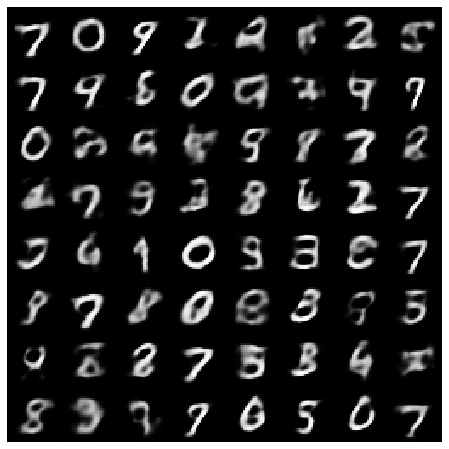

In [47]:
from scipy.stats import norm
from itertools import product
nz = 8
margin = 0.1
zgrid = norm.ppf(np.linspace(margin,1-margin,nz))

x = kws.draw_mean(prior, obs, nz*nz).detach().cpu().numpy()
x = x.reshape(x.shape[0], nc, image_size, image_size)
x = np.transpose(x, (0,2,3,1))
x = x.reshape(nz,nz,image_size,image_size,nc)

x = np.concatenate(x,-2)
x = np.concatenate(x,0)
if nc == 1:
    x = x[...,0]
plt.figure(figsize=(8,8))
if x.min() < 0:
    x = x/2. + 0.5
plt.imshow(x, cmap="gray")
plt.gca().set_axis_off()
# plt.savefig("figs/mnist_10d_after_2.pdf", bbox_inches='tight', pad_inches=0)